
=== AUDCAD ===
   Level  Buy  Sell  Total
0      1  121   116    237
1      2   35    32     67
2      3   10     9     19
3      4    3     3      6
4      5    1     3      4
5      6    0     1      1


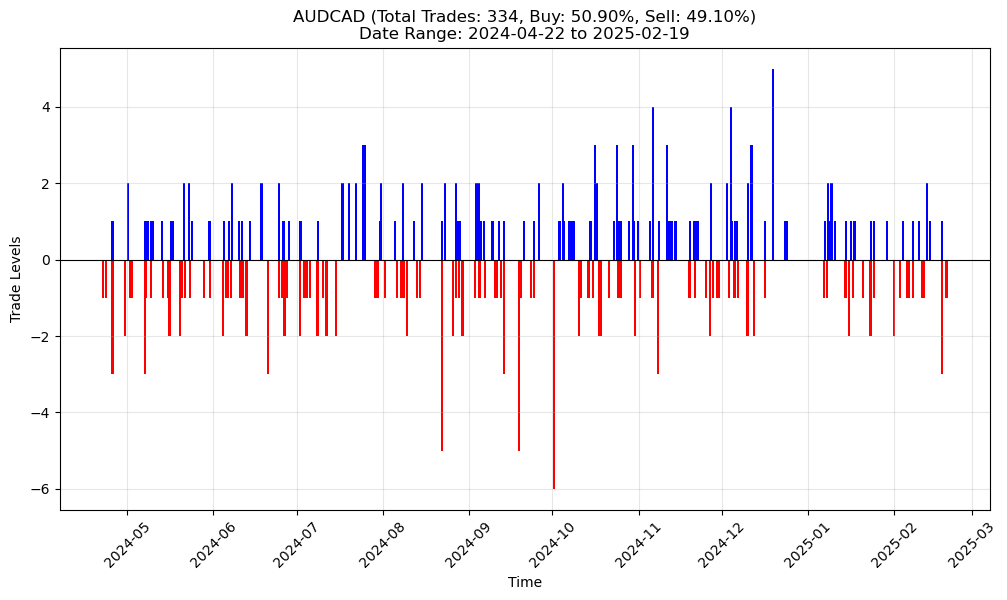


=== AUDCHF ===
    Level  Buy  Sell  Total
0       1   91    66    157
1       2   27    16     43
2       3   10     6     16
3       4    2     2      4
4       5    1     2      3
5       6    1     2      3
6       7    1     1      2
7       8    1     1      2
8       9    1     1      2
9      10    1     0      1
10     11    1     0      1
11     12    1     0      1


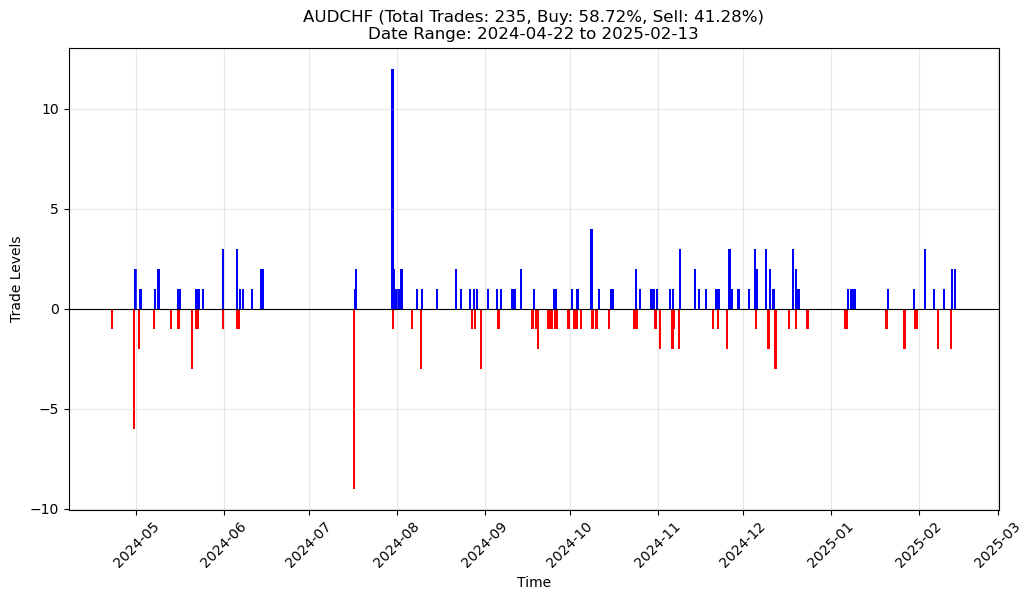


=== AUDNZD ===
   Level  Buy  Sell  Total
0      1  102   106    208
1      2   20    28     48
2      3   10     8     18
3      4    2     2      4
4      5    1     1      2
5      6    1     1      2
6      7    1     0      1
7      8    1     0      1


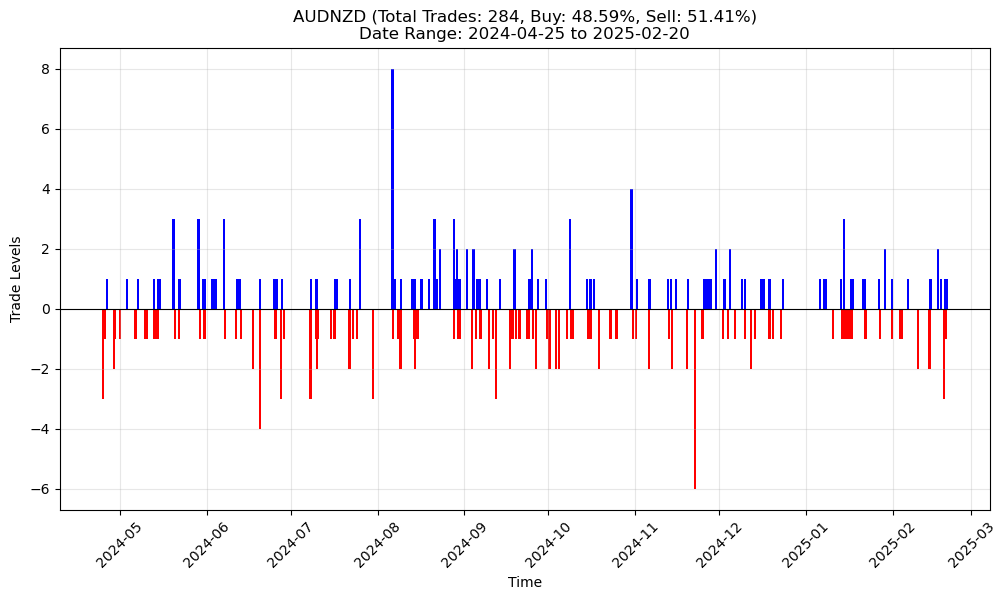


=== AUDUSD ===
    Level  Buy  Sell  Total
0       1  115   102    217
1       2   27    28     55
2       3   10     5     15
3       4    3     2      5
4       5    2     1      3
5       6    2     1      3
6       7    1     1      2
7       8    1     0      1
8       9    1     0      1
9      10    1     0      1
10     11    1     0      1
11     12    1     0      1


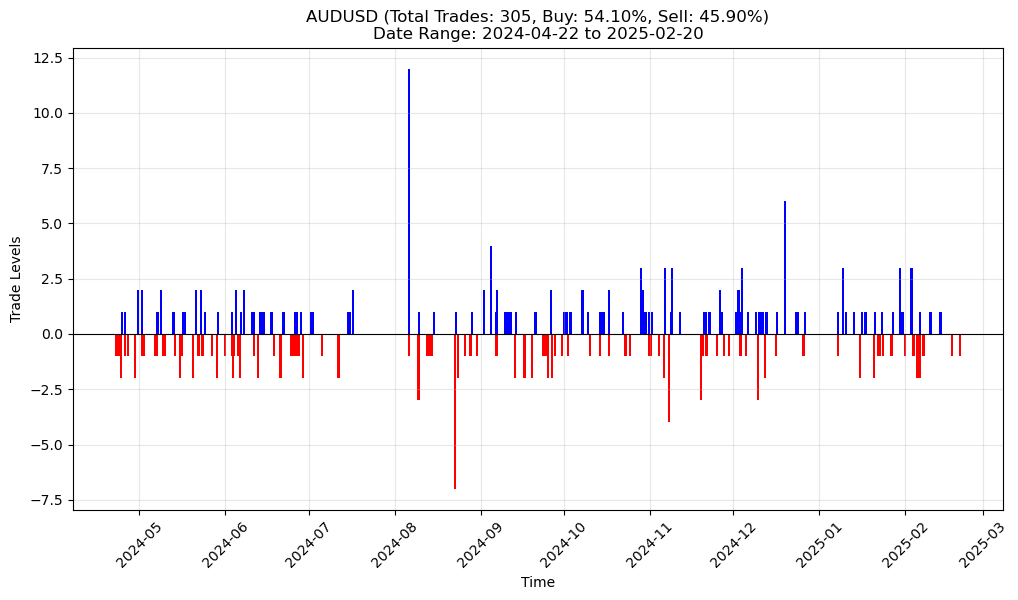


=== CADCHF ===
    Level  Buy  Sell  Total
0       1   68    70    138
1       2   23    20     43
2       3    8     6     14
3       4    4     2      6
4       5    3     1      4
5       6    2     1      3
6       7    2     1      3
7       8    1     0      1
8       9    1     0      1
9      10    1     0      1
10     11    1     0      1
11     12    1     0      1
12     13    1     0      1
13     14    1     0      1
14     15    1     0      1
15     16    1     0      1
16     17    1     0      1


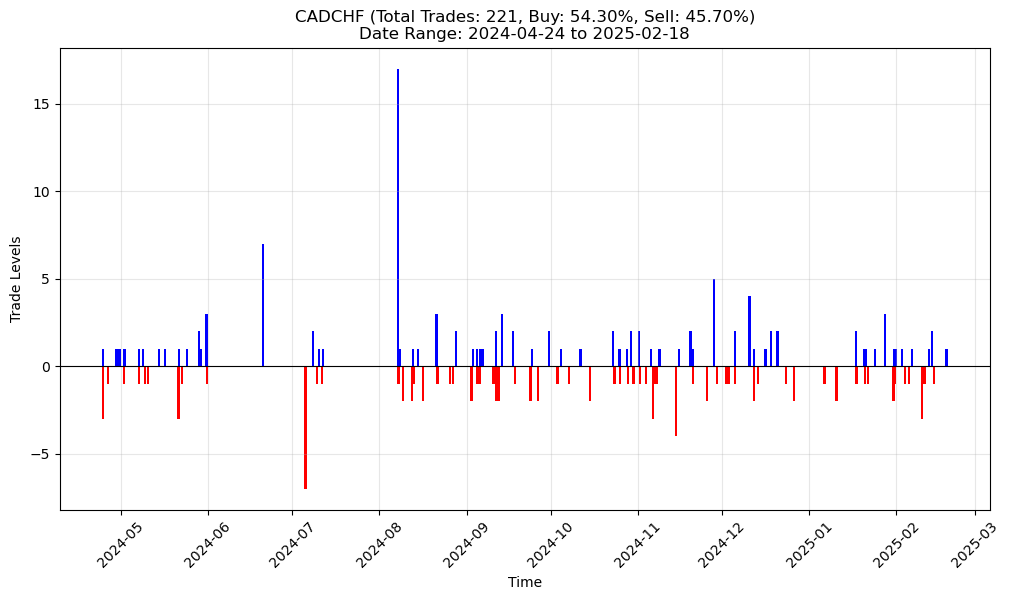


=== EURAUD ===
   Level  Buy  Sell  Total
0      1  139   147    286
1      2   21    22     43
2      3    4     5      9
3      4    0     3      3
4      5    0     1      1


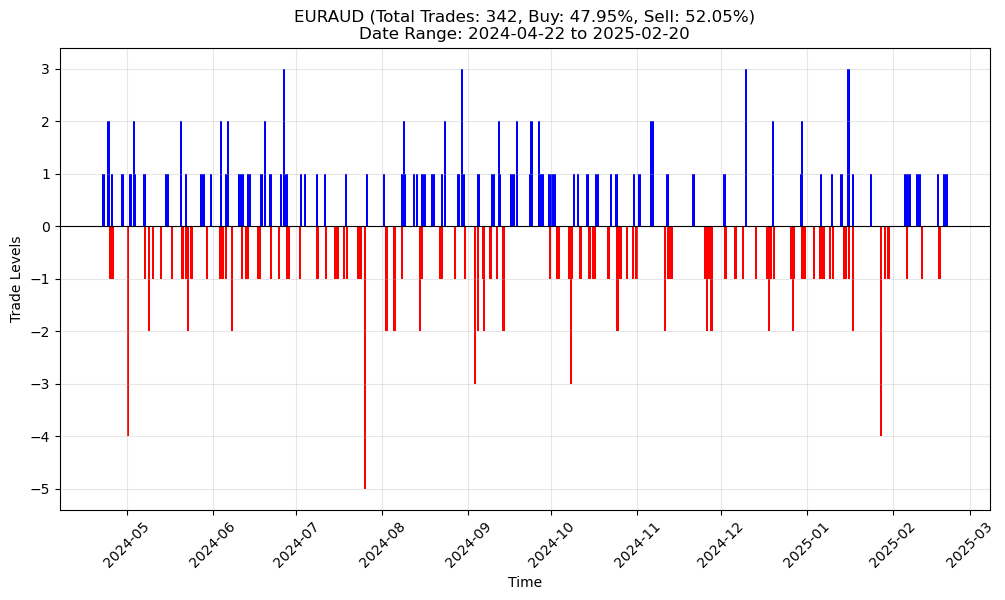


=== EURCAD ===
   Level  Buy  Sell  Total
0      1  104   121    225
1      2   19    27     46
2      3    7     9     16
3      4    3     3      6
4      5    2     2      4
5      6    1     2      3
6      7    1     1      2


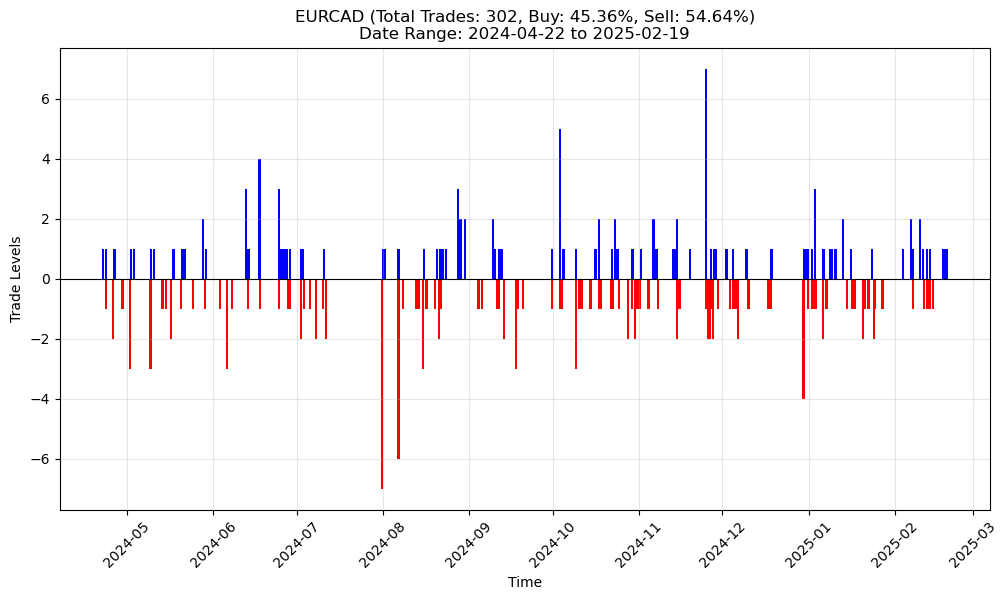


=== EURCHF ===
   Level  Buy  Sell  Total
0      1  130   108    238
1      2   31    29     60
2      3   12     9     21
3      4    6     6     12
4      5    4     3      7
5      6    1     1      2
6      7    0     1      1


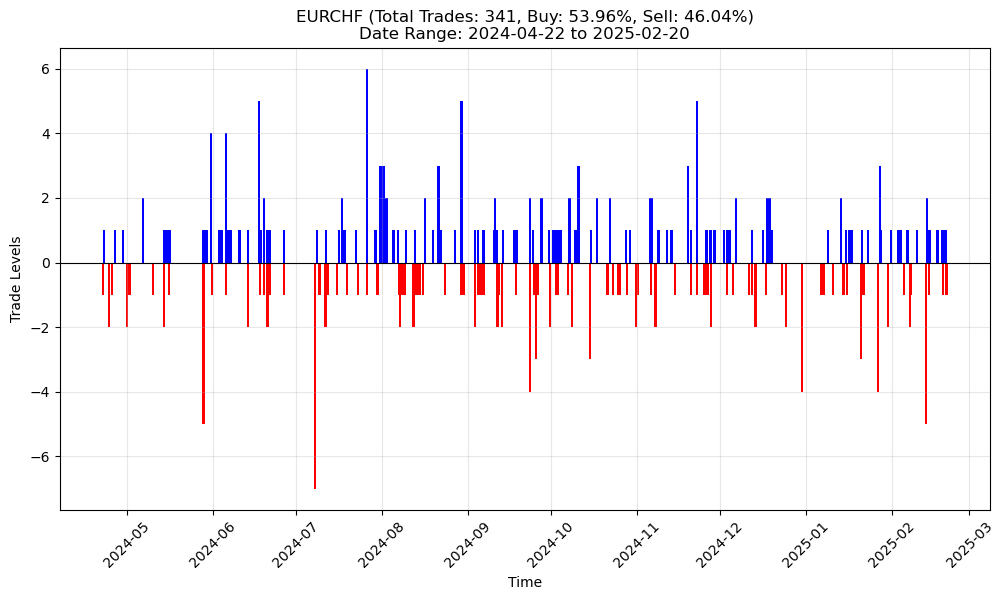


=== EURGBP ===
   Level  Buy  Sell  Total
0      1   66    65    131
1      2   23    19     42
2      3    7     4     11
3      4    4     2      6
4      5    2     2      4
5      6    1     1      2
6      7    0     1      1


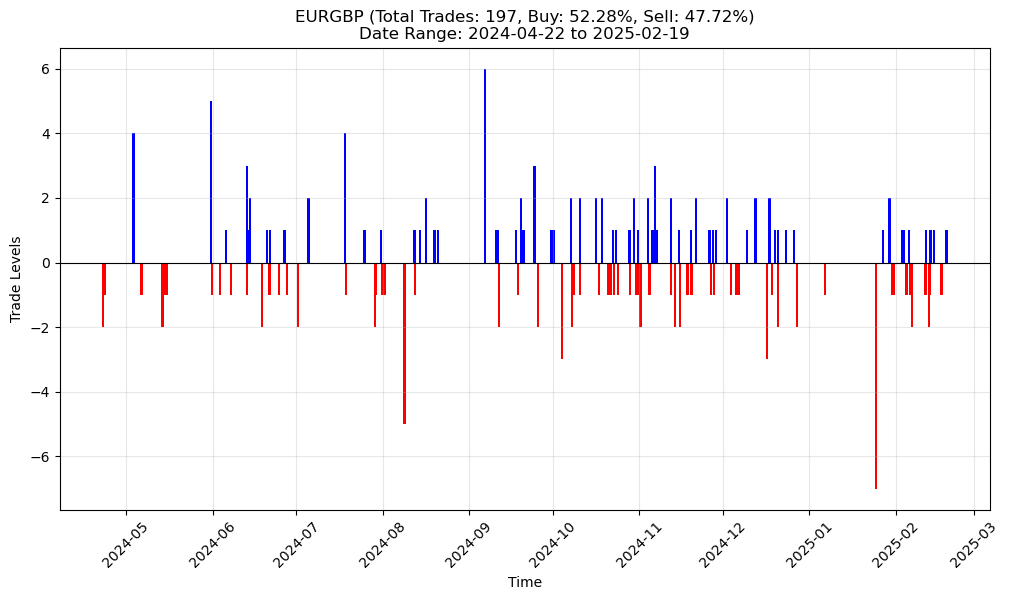


=== EURNZD ===
   Level  Buy  Sell  Total
0      1  111    71    182
1      2   25    18     43
2      3    2     5      7
3      4    1     1      2


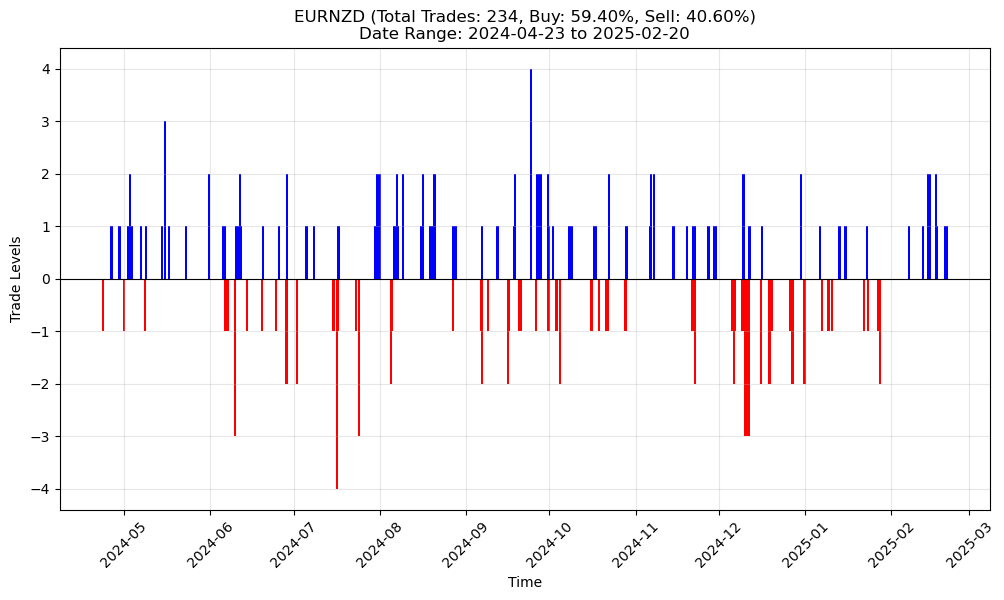


=== EURUSD ===
   Level  Buy  Sell  Total
0      1  140   127    267
1      2   26    23     49
2      3    5     8     13
3      4    3     1      4


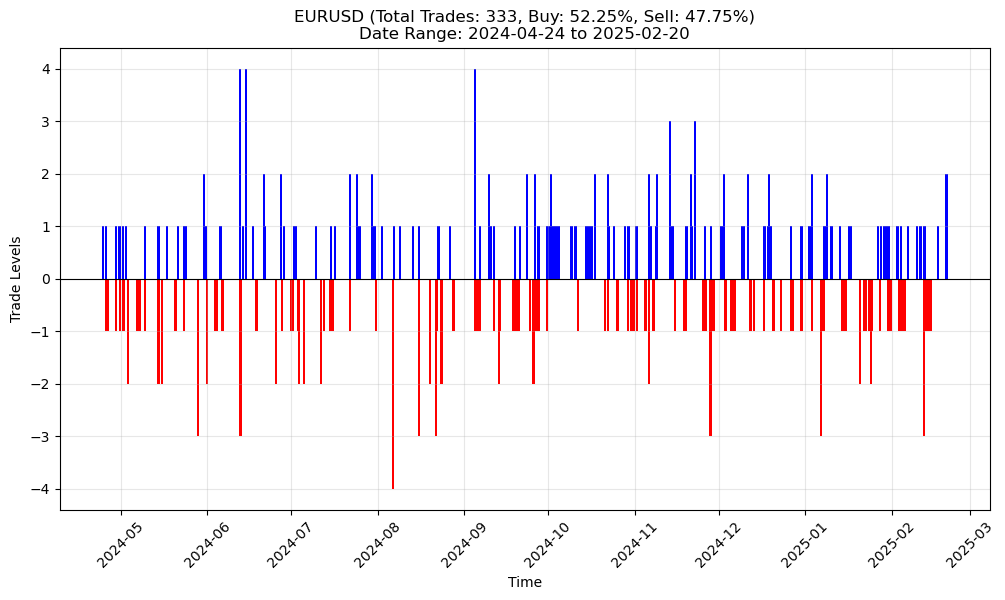


=== GBPAUD ===
    Level  Buy  Sell  Total
0       1   66    69    135
1       2    6    10     16
2       3    0     3      3
3       4    0     2      2
4       5    0     2      2
5       6    0     2      2
6       7    0     2      2
7       8    0     2      2
8       9    0     2      2
9      10    0     1      1
10     11    0     1      1


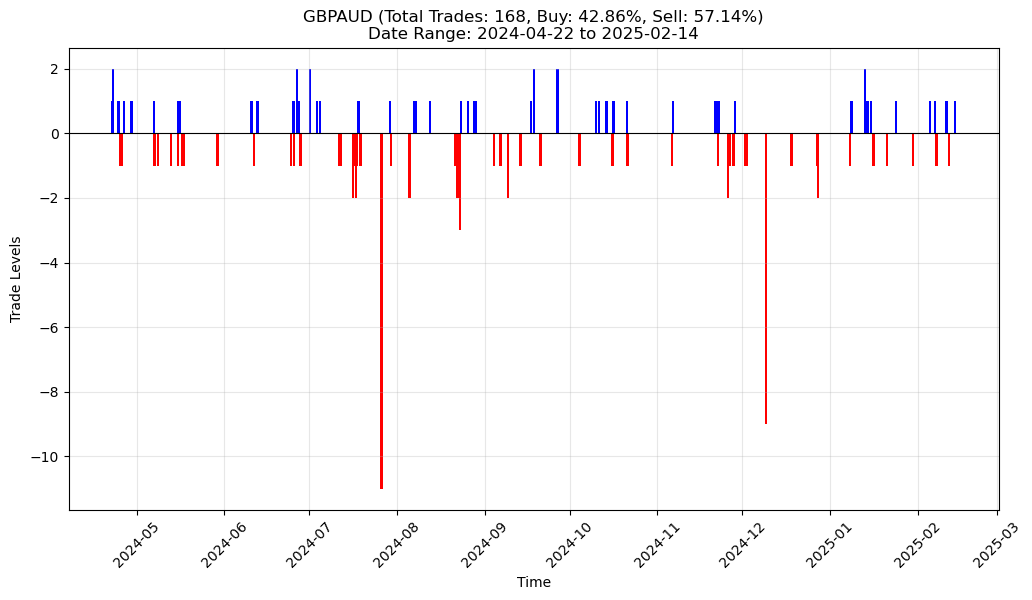


=== GBPCAD ===
   Level  Buy  Sell  Total
0      1   67   108    175
1      2   18    15     33
2      3    8     5     13
3      4    6     3      9
4      5    4     2      6
5      6    2     1      3
6      7    1     1      2
7      8    1     1      2


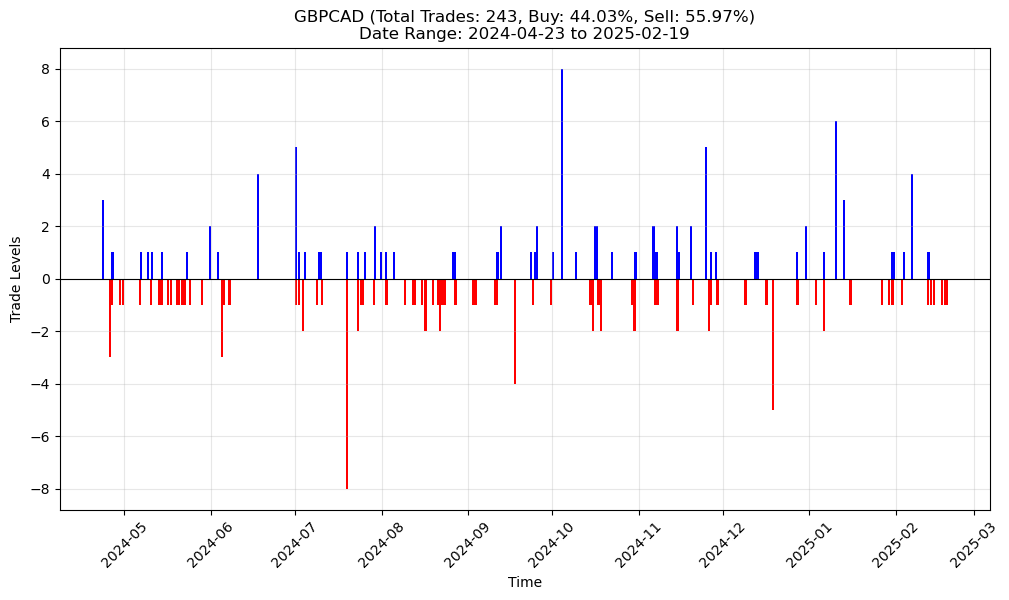


=== GBPCHF ===
   Level  Buy  Sell  Total
0      1  122   118    240
1      2   28    25     53
2      3    9     9     18
3      4    3     4      7
4      5    2     2      4
5      6    1     1      2
6      7    1     0      1
7      8    1     0      1
8      9    1     0      1


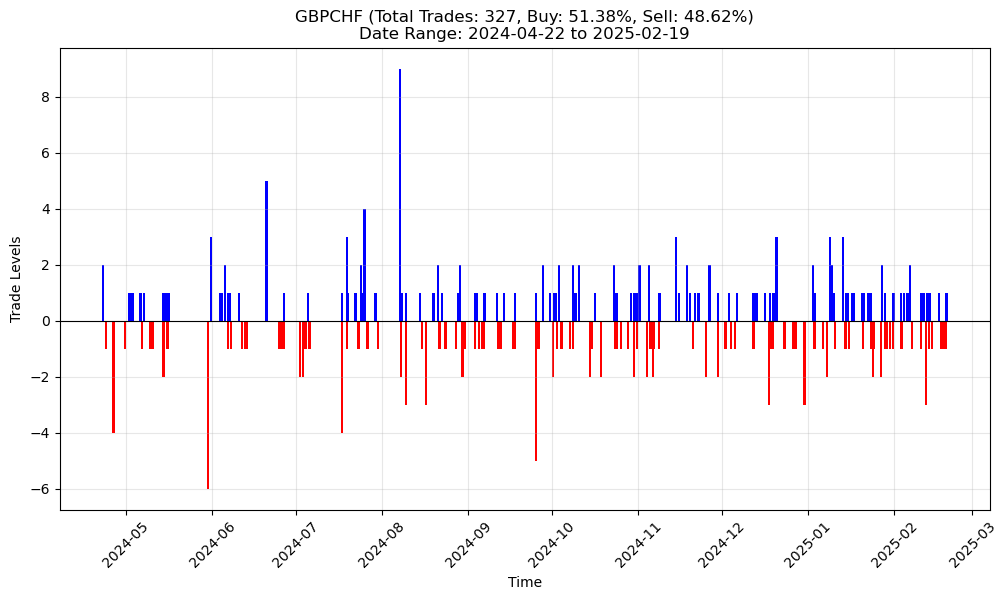


=== GBPNZD ===
   Level  Buy  Sell  Total
0      1   32    38     70
1      2    9     7     16
2      3    3     1      4
3      4    2     0      2
4      5    2     0      2


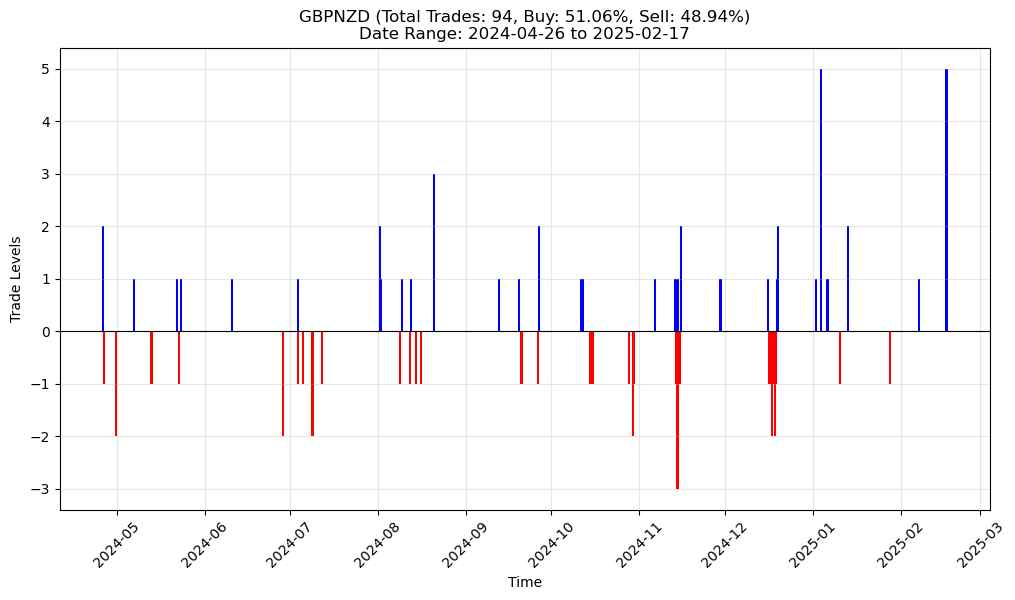


=== GBPUSD ===
    Level  Buy  Sell  Total
0       1  128   132    260
1       2   26    25     51
2       3    6     7     13
3       4    2     2      4
4       5    1     2      3
5       6    1     2      3
6       7    1     2      3
7       8    1     2      3
8       9    1     2      3
9      10    1     0      1
10     11    1     0      1


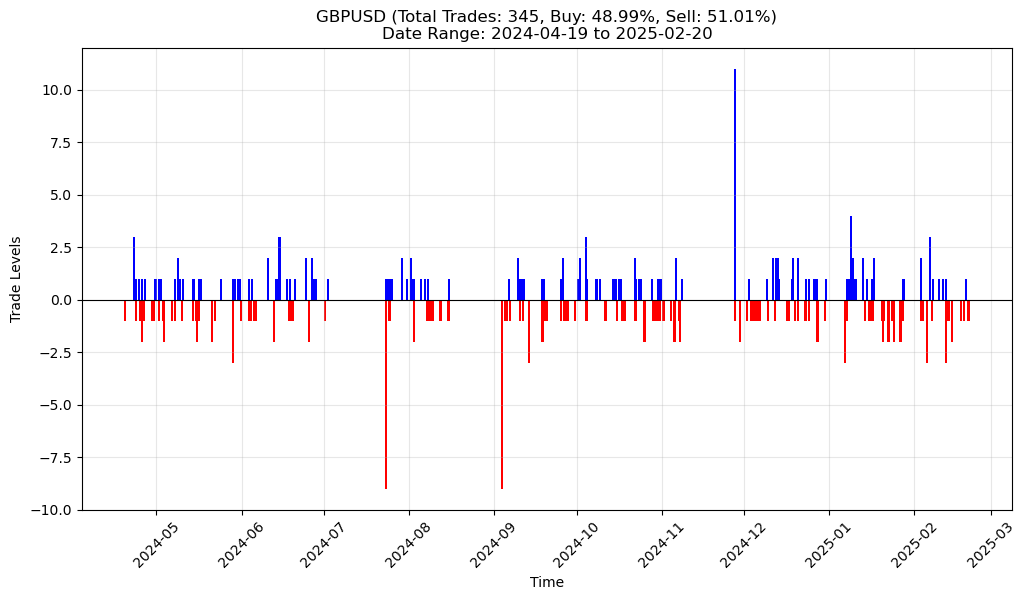


=== NZDCAD ===
   Level  Buy  Sell  Total
0      1  107   119    226
1      2   33    33     66
2      3   11    13     24
3      4    5     3      8
4      5    4     1      5
5      6    1     0      1
6      7    1     0      1
7      8    1     0      1


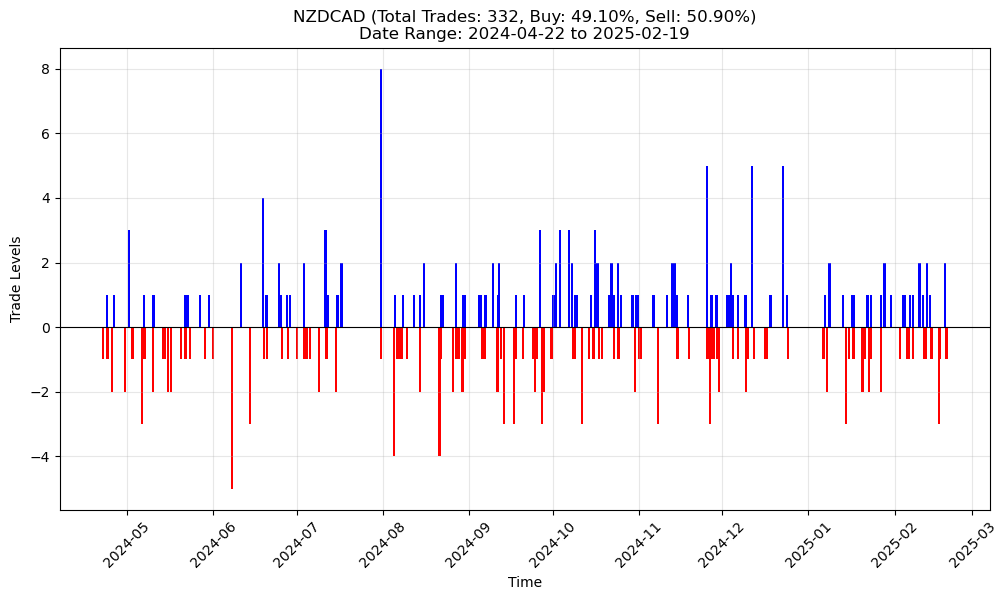


=== NZDCHF ===
    Level  Buy  Sell  Total
0       1   78    61    139
1       2   26    15     41
2       3    8     2     10
3       4    4     1      5
4       5    2     1      3
5       6    1     1      2
6       7    1     0      1
7       8    1     0      1
8       9    1     0      1
9      10    1     0      1
10     11    1     0      1
11     12    1     0      1
12     13    1     0      1
13     14    1     0      1
14     15    1     0      1
15     16    1     0      1
16     17    1     0      1


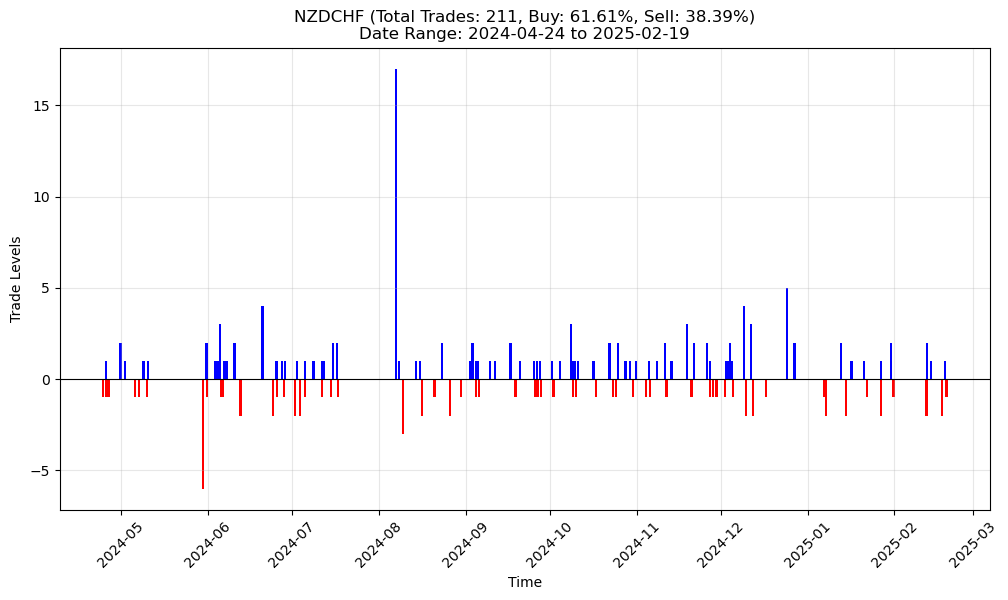


=== NZDUSD ===
   Level  Buy  Sell  Total
0      1   74    87    161
1      2   27    24     51
2      3   10     8     18
3      4    5     5     10
4      5    3     2      5
5      6    3     1      4
6      7    3     1      4
7      8    0     1      1
8      9    0     1      1
9     10    0     1      1


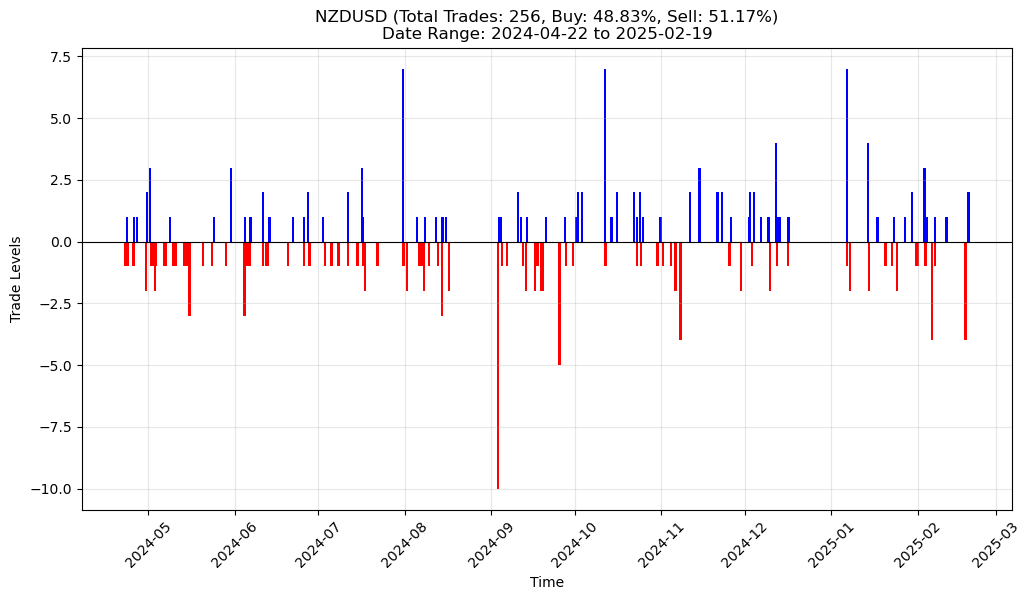


=== USDCAD ===
   Level  Buy  Sell  Total
0      1  113   137    250
1      2   20    28     48
2      3    7     6     13
3      4    1     4      5
4      5    0     1      1


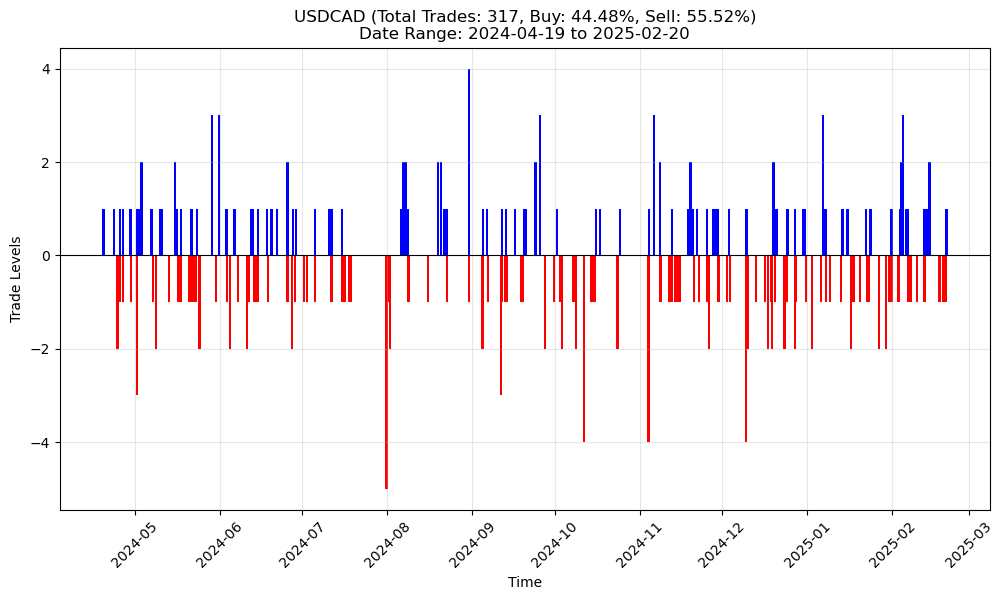


=== USDCHF ===
   Level  Buy  Sell  Total
0      1  103   110    213
1      2   25    21     46
2      3    9     6     15
3      4    4     3      7
4      5    2     2      4
5      6    2     0      2
6      7    2     0      2


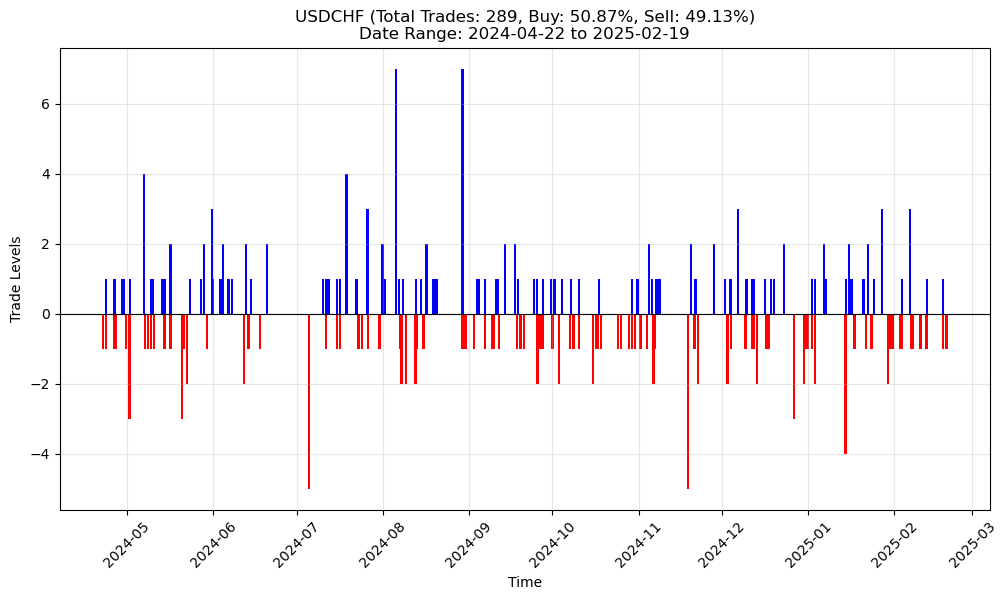


=== XAUUSD ===
   Level  Buy  Sell  Total
0      1   24    55     79
1      2    2    10     12
2      3    0     4      4
3      4    0     2      2
4      5    0     2      2


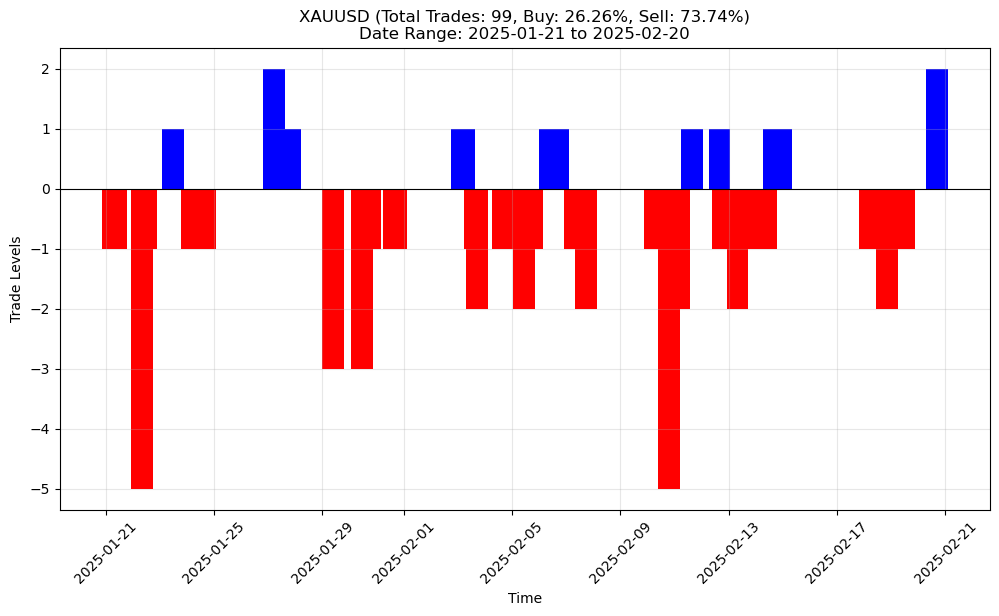

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def read_and_prepare_data(filename):
    df = pd.read_excel(filename)
    df['Open Time'] = pd.to_datetime(df['Open Time'], format='%Y.%m.%d %H:%M:%S')
    df['Close Time'] = pd.to_datetime(df['Close Time'], format='%Y.%m.%d %H:%M:%S')
    return df

def determine_level(lot_size):
    if lot_size <= 0.04:
        return round(lot_size / 0.01)
    else:
        return round((lot_size - 0.4) / 0.1) + 4

def calculate_cycle_lengths(pair_df):
    cycle_lengths = []
    max_levels = []
    
    current_cycle = []
    
    for _, row in pair_df.iterrows():
        level = determine_level(row['Size'])
        if row['Type'] == 'buy':
            current_cycle.append((row['Open Time'], level))
        elif row['Type'] == 'sell' and current_cycle:
            start_time, max_level = max(current_cycle, key=lambda x: x[1])
            cycle_length = (row['Close Time'] - start_time).total_seconds()
            cycle_lengths.append((max_level, cycle_length))
            current_cycle = []  # Reset for next cycle
            
    return cycle_lengths

def analyze_trades(df):
    results = {}
    
    for pair in df['Item'].unique():
        pair_df = df[df['Item'] == pair]
        buy_trades = pair_df[pair_df['Type'] == 'buy']
        sell_trades = pair_df[pair_df['Type'] == 'sell']
        
        buy_levels = {}
        sell_levels = {}
        
        for _, row in buy_trades.iterrows():
            level = determine_level(row['Size'])
            buy_levels[level] = buy_levels.get(level, 0) + 1
        
        for _, row in sell_trades.iterrows():
            level = determine_level(row['Size'])
            sell_levels[level] = sell_levels.get(level, 0) + 1
        
        levels = sorted(set(buy_levels.keys()).union(sell_levels.keys()))
        df_levels = pd.DataFrame({'Level': levels})
        df_levels['Buy'] = df_levels['Level'].map(buy_levels).fillna(0).astype(int)
        df_levels['Sell'] = df_levels['Level'].map(sell_levels).fillna(0).astype(int)
        df_levels['Total'] = df_levels['Buy'] + df_levels['Sell']

        # Calculate cycle-based trade lengths
        cycle_lengths = calculate_cycle_lengths(pair_df)
        cycle_df = pd.DataFrame(cycle_lengths, columns=['Level', 'Cycle Length'])
        avg_cycle_length = cycle_df.groupby('Level')['Cycle Length'].mean()
        df_levels['Avg Cycle Length'] = df_levels['Level'].map(avg_cycle_length).fillna(0).round(2)
        
        results[pair.upper()] = {
            'df_levels': df_levels,
            'buy_percentage': (df_levels['Buy'].sum() / df_levels['Total'].sum() * 100) if df_levels['Total'].sum() > 0 else 0,
            'sell_percentage': (df_levels['Sell'].sum() / df_levels['Total'].sum() * 100) if df_levels['Total'].sum() > 0 else 0,
            'pair_df': pair_df
        }
    
    return results

def plot_trade_distribution(results, pair, date_range):
    pair_df = results[pair]['pair_df'].sort_values('Close Time')
    
    plt.figure(figsize=(12, 6))
    y_positions = []
    colors = []
    
    for _, row in pair_df.iterrows():
        level = determine_level(row['Size'])
        if row['Type'] == 'buy':
            y_positions.append(level)
            colors.append('blue')
        else:
            y_positions.append(level)  # Maintain positive level values
            colors.append('red')
    
    plt.bar(pair_df['Close Time'], y_positions, color=colors)
    plt.axhline(0, color='black', linewidth=0.8)
    plt.xlabel('Time')
    plt.ylabel('Trade Levels')
    total_trades = results[pair]['df_levels']['Total'].sum()
    title = f"{pair} (Total Trades: {total_trades}, Buy: {results[pair]['buy_percentage']:.2f}%, Sell: {results[pair]['sell_percentage']:.2f}%)"
    title += f"\nDate Range: {date_range}"
    plt.title(title)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.show()

def generate_trade_report(results, df):
    date_range = f"{df['Open Time'].min().strftime('%Y-%m-%d')} to {df['Close Time'].max().strftime('%Y-%m-%d')}"
    for pair, data in results.items():
        print(f"\n=== {pair} ===")
        print(data['df_levels'].to_string(index=False))  # Remove extra index
        plot_trade_distribution(results, pair, date_range)

df = read_and_prepare_data('shadowhistory.xlsx')
df['Profit'] = pd.to_numeric(df['Profit'], errors='coerce')
df['Profit'].fillna(0, inplace=True)
results = analyze_trades(df)
generate_trade_report(results, df)
